In [26]:
import pandas as pd
import openai
from dotenv import load_dotenv
import os, json, random, re
import ast
import numpy as np
load_dotenv()

# Set the OpenAI API key
OpenAI_Client = openai.OpenAI(
    default_headers={
        "HTTP-Referer": "cfe-paper",
    },
    base_url="https://openrouter.ai/api/v1",
    api_key=os.getenv("OPENROUTER_API_KEY"),
    
)
EVAL_MODEL = "openai/gpt-5"

In [3]:
path = "../data/results/100q_results_filtered.csv"
df_all = pd.read_csv(path)
# sample 2 examples from each model-prompt_variant combination
# df_sample = df_all.groupby(["model", "prompt_variant"]).apply(lambda x: x.sample(n=4)).reset_index(drop=True)

In [ ]:
EVAL_MODEL = "gpt-5"

def evaluate_responses_1st_layer(question: str, model_response: str):
    system_prompt = """
## Task Definition

You are an expert question evaluator. Your task is to rate a question on how likely it is that  people, when asked, might mix up the true answer with other plausible but incorrect alternatives.

Do **not** try to answer the question explicitly. Base your judgment only on the question itself and general world knowledge.

So the question will have a high score if:

* Although **people have some knowledge about the question**, they might still mix up that correct answer with other incorrect alternatives.
* The questions often make people with some level of knowledge about the topic second‑guess themselves ("It was X, right? Or was it Y?") will receive higher scores.
* Some reasons for this mix up might be:

  * They can be similar entities or objects.
  * They can be considered in the terms of similar definitions by the people.

The question will have a low score if:

* BUT it's rare that people mix the correct answer, if they have some information about the question.
* Question has a straightforward answer, if somebody is informed about the topic they can just answer it and they do not need to clarify anything.
* Examples could be like historical dates, scientific questions with certain answers, absolute facts etc.

**DISCLAIMER** : While saying "mix up", we don't mean responses given by people that has no knowledge about the topic.
We do not consider the shots in the dark as "mix up". People answering these questions have some knowledge about the question.
They don't have to be experts, just some having some information about the topic is enough.
So clueless and baseless attempts to respond are not considered as "mix ups".

Scoring examples (0–100):

* 0–15: Straightforward; people rarely mix it up.
* 16–40: Mostly clear; a couple of mild slips possible.
* 41–65: Often causes hesitation with reasonable alternatives.
* 66–85: Frequently makes people go back and forth between several plausible options.
* 86–100: Extremely likely to cause uncertainty with many convincing alternatives.

**Output format (strict):**
Explanation: <1–3 sentences of reasoning>
Score: <integer 0–100>
    """ 
    user_prompt = f"""
    Question: {question}
    """
    res = OpenAI_Client.chat.completions.create(
        model=EVAL_MODEL,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
            ],
         response_format={
            "type": "text"
        },
        reasoning_effort="medium"
            )
    
    response_text = res.choices[0].message.content.strip()
    response_text_lines = response_text.splitlines()
    explanation = re.search(r"Explanation:\s*(.*)", response_text, re.IGNORECASE)
    score = re.search(r"Score:\s*(\d+)", response_text, re.IGNORECASE)

    print(f"Question: {question}\n1st Layer Result:\n{response_text}\n")
    return explanation, score

In [ ]:
# run the evaluation on the sampled dataframe
counter = 0
def evaluate_df(df):
    """
    Evaluate once per unique question, then attach the score/explanation
    to every row with that question. Preserves all original columns.
    """
    # Evaluate per unique question (use first available llm_response if needed)
    q2eval = {}
    for q, sub in df.groupby("question"):
        # Layer-1 only needs the question; pass a representative response if your function signature requires it
        model_response = sub["llm_response"].iloc[0] if "llm_response" in sub.columns else ""
        explanation, score = evaluate_responses(q, model_response)

        if explanation and score:
            q2eval[q] = {
                "1st_layer_score": int(score.group(1).strip()),
                "1st_layer_explanation": explanation.group(1).strip(),
            }
        else:
            q2eval[q] = {
                "1st_layer_score": np.nan,
                "1st_layer_explanation": np.nan,
            }
        global counter
        counter += 1

    # Map results back to every row sharing that question
    df_out = df.copy()
    df_out["1st_layer_score"] = df_out["question"].map(lambda q: q2eval.get(q, {}).get("1st_layer_score", np.nan))
    df_out["1st_layer_explanation"] = df_out["question"].map(lambda q: q2eval.get(q, {}).get("1st_layer_explanation", np.nan))

    return df_out


In [8]:
evaluated_df = evaluate_df(df_all)
print(f"Evaluated {counter} unique questions.")
evaluated_df.to_csv("../data/results/100q_1st_eval.csv", index=False)

Question: "Feel Like Making Love" and "The First Time Ever I Saw Your Face" were hit singles for which female artist?
1st Layer Result:Explanation: Both songs have many covers and “Feel Like Makin’ Love” title overlaps with the famous Bad Company track, which can mislead; however, specifying a female artist and pairing the two songs points strongly to one singer. Still, people might hesitate between a few soul/pop vocalists known for similar hits.
Score: 47

Question: Anellini pasta is what type of shape?
1st Layer Result:Explanation: The name derives from Italian “anello” (ring), so anyone with basic pasta knowledge can recall it’s ring-shaped. There’s some chance of mixing it up with similar small shapes like ditalini (tubes) or rotelle (wheels), but the etymology makes it fairly clear.
Score: 38

Question: Art Garfunkel trained for which profession although he didn't qualify?
1st Layer Result:Explanation: This is a specific biographical detail about a famous musician, but many simil

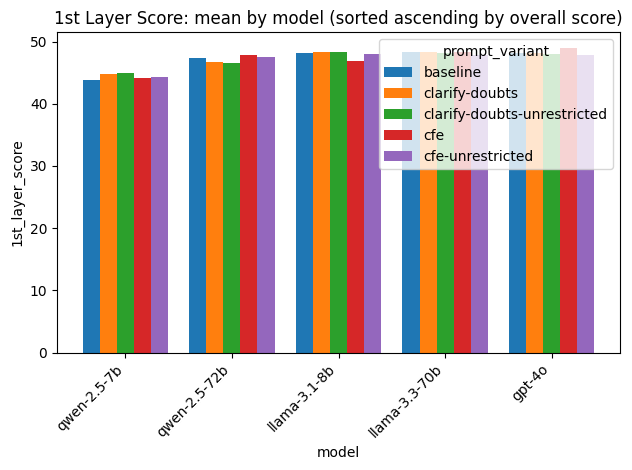

In [9]:
from matplotlib import pyplot as plt



# Order prompts in the requested sequence
desired_order = ["baseline", "clarify-doubts", "clarify-doubts-unrestricted", "cfe", "cfe-unrestricted"]

models = sorted(evaluated_df["model"].dropna().unique().tolist())
prompts = sorted(evaluated_df["prompt_variant"].dropna().unique().tolist())
prompts = sorted(
    prompts,
    key=lambda x: desired_order.index(x) if x in desired_order else len(desired_order)
)

# Compute overall mean GPT score per model
model_means = evaluated_df.groupby("model")["1st_layer_score"].mean().sort_values()

# Reorder models based on ascending average score
models_sorted = model_means.index.tolist()


# Recompute grouped means with reordered models
means_sorted = (
    evaluated_df.groupby(["model", "prompt_variant"])["1st_layer_score"]
      .mean()
      .unstack("prompt_variant")
      .reindex(index=models_sorted, columns=prompts)
)

# Bar plot with sorted models
x = np.arange(len(models_sorted), dtype=float)
n_bars = len(prompts)
width = 0.8 / n_bars
offsets = (np.arange(n_bars) - (n_bars - 1) / 2.0) * width

plt.figure()
for j, pr in enumerate(prompts):
    y = pd.to_numeric(means_sorted[pr], errors="coerce").fillna(0).values
    plt.bar(x + offsets[j], y, width=width, label=str(pr))

plt.title("1st Layer Score: mean by model (sorted ascending by overall score)")
plt.xlabel("model")
plt.ylabel("1st_layer_score")
plt.xticks(ticks=x, labels=models_sorted, rotation=45, ha="right")
plt.legend(title="prompt_variant")
plt.tight_layout()

plt.show()

In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
evaluated_df = pd.read_csv("../data/results/100q_1st_eval.csv")

12 82 48.94318181818182 56.5
38
50


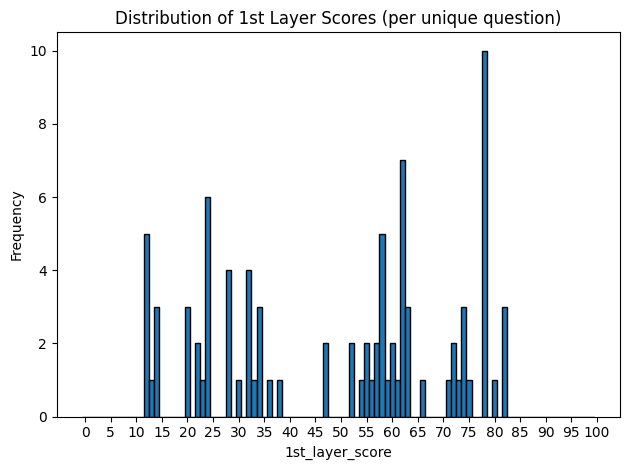

In [6]:
# one score per unique question
scores = (evaluated_df
          .drop_duplicates(subset=["question"])["1st_layer_score"]
          .dropna()
          .astype(int))

print(np.min(scores), np.max(scores), np.mean(scores), np.median(scores))
# number of scores that is less than 50
print(scores[scores < 50].shape[0])
# number of scores that is 50 or more
print(scores[scores >= 50].shape[0])

# integer-aligned bins
bins = np.arange(-0.5, 100.5, 1)

plt.figure()
plt.hist(scores, bins=bins, edgecolor="black")
plt.title("Distribution of 1st Layer Scores (per unique question)")
plt.xlabel("1st_layer_score")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 101, 5))
plt.tight_layout()
plt.show()


In [38]:
import json, re, numpy as np


CONFUSING_SYSTEM_PROMPT = """
You are an objective evaluator for Counterfactual-Explanatory QA (CFE).
You will receive a Question and a Model Response.
The question requires clarifications about plausible but incorrect alternative answers.

Definition of a clarification: explicitly naming one or more plausible alternative answers that a person might mix up with 
the correct answer, and explaining why each is incorrect (via definition/scope constraints, time/place, mechanism, 
numeric mismatch or other explanations).

Score the Model Response on 0–100 (additive):
Sufficiency (0–40):
0: no clarifications.
~20: at least one explicit plausible alternative is named with a minimally adequate clarification.
~30: addresses the key likely alternative(s) with clear clarifications.
~40: comprehensively covers the main likely alternative(s) with clear distinctions.
(Do not require a specific number of alternatives; judge adequacy relative to the question.)

Targeting (0–40):
0: irrelevant alternatives.
~20: mixed plausibility (some relevant, some weak).
~40: all addressed alternatives are genuinely plausible for this question and align with potential mix ups.

Clarification soundness (0–20):
0: incorrect clarification.
~10: partially specific or incomplete.
~20: concrete, constraint-based reasons with no logic errors.

Output strictly in JSON:
{
  "justification": "<explaining the scoring in an objective way>",
  "breakdown": {
    "sufficiency": <0-40>,
    "targeting": <0-40>,
    "clarification_soundness": <0-20>
  },
    "score": <integer 0-100>
}
"""

NONCONFUSING_SYSTEM_PROMPT = """
You are an objective model response evaluator.
You will receive a Question and a Model Response.
For the given questions, clarifications are not expected. Model responses should avoid any clarifications.

Evaluate only:
1) No clarifications about alternatives (naming or implying alternatives like “often confused with X/Y”, “could also be Z” violates restraint).
2) No factual incorrectness.

Scoring on 0-100 (additive):
No clarifications (0-60):
0: contains many clarifications about alternatives.
~30: minor, vague, or indirect references to alternatives.
60: no clarifications about alternatives.
No factual errors (0-40):
0: contains many factual errors in any extra statements.
~20: minor factual inaccuracies or ambiguities.
40: no factual errors.


Output strictly in JSON:
{
  "justification": "<explaining any violation or stating compliance>",
  "breakdown": {
    "no_clarifications": <0-60>,
    "no_factual_errors": <0-40>
  },
  "score": <0 or 100>
}
"""
def _force_json(s: str):
    """Best-effort JSON extraction from model output."""
    s = s.strip()
    try:
        return json.loads(s)
    except Exception:
        # Find the first {...} block and parse it
        m = re.search(r"\{[\s\S]*\}", s)   # more permissive regex
        if m:
            try:
                return json.loads(m.group(0))
            except Exception as e:
                print("Raw output (failed JSON):", s)
                raise ValueError(f"Could not parse extracted JSON: {e}")
        print("Raw output (no JSON found):", s)
        raise ValueError("Second-layer evaluator did not return valid JSON.")


def evaluate_responses_2nd_layer(question: str,
                                 model_response: str,
                                 first_layer_score: float,
                                 eval_model: str = EVAL_MODEL):
    """
    Routes by first_layer_score and evaluates with the appropriate system prompt.
    Returns a dict with keys: score, breakdown (dict or None), flags (dict), justification (str), branch ('confusing'|'non_confusing').
    """
    if first_layer_score is None or (isinstance(first_layer_score, float) and np.isnan(first_layer_score)):
        return {"score": None, "breakdown": None, "flags": {}, "justification": "no first-layer score", "branch": None}

    branch = "confusing" if first_layer_score >= 50 else "non_confusing"
    system_prompt = CONFUSING_SYSTEM_PROMPT if branch == "confusing" else NONCONFUSING_SYSTEM_PROMPT

    user_prompt = f"Question: {question}\nModel Response: {model_response}"

    res = OpenAI_Client.chat.completions.create(
        model=eval_model,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        # Keep 'text' to match your current client usage; model is instructed to output strict JSON.
        response_format={"type": "text"},
        reasoning_effort="medium",
        max_tokens=1000,
    )
    raw = res.choices[0].message.content
    data = _force_json(raw)

    # Normalize shape across branches
    out = {
        "score": data.get("score"),
        "breakdown": data.get("breakdown") if "breakdown" in data else None,
        "flags": data.get("flags", {}),
        "justification": data.get("justification", ""),
        "branch": branch,
        "raw_json": data,  # keep original for debugging if you like
    }
    return out

# --- Minimal changes to your evaluate_df ---

def _jsondump(obj):
    try:
        return json.dumps(obj, ensure_ascii=False)
    except Exception:
        # Last resort stringification
        return str(obj)

def evaluate_df(df, layer_type, save_path="100q_2nd_eval.csv", checkpoint_every=5):
    """
    layer_type = 1 -> run first-layer evaluator once per unique question and attach:
                    '1st_layer_score', '1st_layer_explanation'
    layer_type = 2 -> run second-layer evaluator per row (requires '1st_layer_score' in df) and attach ONLY:
                    '2nd_layer_score', '2nd_layer_json'
    """
    if layer_type not in (1, 2):
        raise ValueError("layer_type must be 1 or 2")

    df_out = df.copy()

    if layer_type == 1:
        # --- Layer-1: evaluate once per unique question ---
        q2eval = {}
        for q, sub in df_out.groupby("question"):
            model_response = sub["llm_response"].iloc[0] if "llm_response" in sub.columns else ""
            explanation, score = evaluate_responses_1st_layer(q, model_response)  # your existing function

            if explanation and score:
                q2eval[q] = {
                    "1st_layer_score": int(score.group(1).strip()),
                    "1st_layer_explanation": explanation.group(1).strip(),
                }
            else:
                q2eval[q] = {"1st_layer_score": np.nan, "1st_layer_explanation": np.nan}

        df_out["1st_layer_score"] = df_out["question"].map(lambda q: q2eval.get(q, {}).get("1st_layer_score", np.nan))
        df_out["1st_layer_explanation"] = df_out["question"].map(lambda q: q2eval.get(q, {}).get("1st_layer_explanation", np.nan))
        return df_out

    # --- Layer-2: requires first-layer scores to be present ---
    if "1st_layer_score" not in df_out.columns:
        raise ValueError("Layer-2 evaluation requires '1st_layer_score' in df. Run layer_type=1 first or merge precomputed scores.")

    # Initialize columns if not present (for resume safety)
    if "2nd_layer_score" not in df_out.columns:
        df_out["2nd_layer_score"] = np.nan
    if "2nd_layer_json" not in df_out.columns:
        df_out["2nd_layer_json"] = None

    cache = {}
    total = len(df_out)

    for i, (idx, row) in enumerate(df_out.iterrows(), 1):
        # Skip if already evaluated (resume functionality)
        if not pd.isna(row["2nd_layer_score"]):
            continue

        q = row.get("question", "")
        resp = row.get("llm_response", "")
        fls = row.get("1st_layer_score", np.nan)

        if fls is None or (isinstance(fls, float) and np.isnan(fls)):
            result = {"score": None, "raw_json": {"error": "no first-layer score"}}
        else:
            branch = "confusing" if float(fls) >= 50.0 else "non_confusing"
            key = (q, resp, branch)
            if key in cache:
                result = cache[key]
            else:
                result = evaluate_responses_2nd_layer(
                    question=q,
                    model_response=resp,
                    first_layer_score=float(fls),
                    eval_model=EVAL_MODEL,
                )
                raw_json = result.get("raw_json", result)
                result = {"score": result.get("score"), "raw_json": raw_json}
                cache[key] = result
            print(f"1st layer score: {fls}, branch: {branch}")
            print(f"Justification: {raw_json.get('justification', '')}\n")
            print(f"Score: {result.get('score')}, Breakdown: {raw_json.get('breakdown')}\n")


        # Update row in df_out
        df_out.at[idx, "2nd_layer_score"] = result.get("score")
        df_out.at[idx, "2nd_layer_json"]  = json.dumps(result.get("raw_json"), ensure_ascii=False)

        # Checkpoint every N rows
        if i % checkpoint_every == 0 or i == total:
            df_out.to_csv(save_path, index=False)
            print(f"Checkpoint saved at row {i}/{total} -> {save_path}")

    return df_out

In [39]:
evaluated_df = pd.read_csv("../data/results/100q_2nd_eval.csv")
evaluate_df(
    evaluated_df,
    layer_type=2,
    save_path="../data/results/100q_2nd_eval.csv"
)

1st layer score: 12, branch: non_confusing
Justification: Direct answer with no mention of alternatives; factually correct that Pelé wore number 10.

Score: 100, Breakdown: {'no_clarifications': 60, 'no_factual_errors': 40}

Raw output (no JSON found): 


ValueError: Second-layer evaluator did not return valid JSON.